# Practical 1: Unsupervised learning and AI Peer-Programming
Our first lecture introduced us to the different types of machine learning, their use cases, and underlying data structures. Given that the course focuses on supervised learning, we use this introductory practice session and shed, at least, some light on *unsupervised learning*.

Further, we use this notebook to illustrate the capabilities of Generative AI (GenAI). More specifically, we examine how GenAI (e.g., ChatGPT), can help us develop Python codes. To that end, the notebook provides a set of prompts to generate Python codes. Your task is to try out these prompts using an AI of your choice and experiment with the generated programming codes. 

We suggest you begin with the prepared prompts. Afterwards, you are most welcome to make adjustments and examine how changes in your prompts change the generated codes; and by extension the effectiveness of the GenAI support. 

**Disclaimer** Prompts were tested with different versions of ChatGTP and should work reasonably well. That said, there is no guarantee that the provided prompts lead an AI to produce ready-to-use code. As said, one learning goal of this session is to *study how GenAI can help us*. We should not expect it to do all the work.

Let's move on with the first prompt.

## Prompt 1: Cluster analysis
Try out the following prompt using an AI of your choice (e.g., ChatGPT):



#### Copy the generated codes into the below code cell and execute it:

Unique true labels: [0 1 2 3 4 5 6]
Unique predicted labels (before mapping): [0 1 2 3 4 5 6]
Label mapping (pred -> true): {4: 0, 5: 1, 0: 2, 2: 3, 1: 4, 6: 5, 3: 6}
Clustering accuracy after optimal mapping: 0.9633
Adjusted Rand Index (ARI): 0.9181
Normalized Mutual Information (NMI): 0.9321


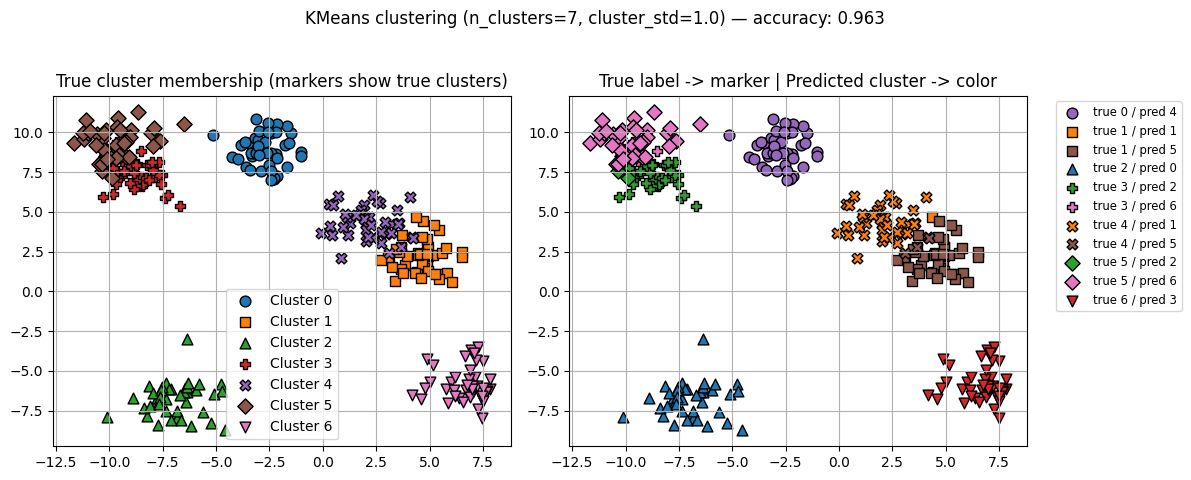

In [12]:
# Copy and run generated codes 
# Demonstration script: 2D synthetic data, scatter plot of true labels,
# run KMeans, and a second plot showing true label (marker) vs predicted (color).
# Run: python clustering_demo.py

import argparse
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment


# Markers to distinguish true clusters (up to 10)
MARKERS = ['o', 's', '^', 'P', 'X', 'D', 'v', '<', '>', '*']


def map_labels_hungarian(true_labels, pred_labels):
    """
    Map predicted cluster indices to true labels using the Hungarian algorithm.
    Returns mapped predictions and the mapping dictionary.
    """
    cm = contingency_matrix(true_labels, pred_labels)
    # maximize matching -> minimize negative
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {}
    for r, c in zip(row_ind, col_ind):
        mapping[c] = r
    mapped = np.array([mapping.get(p, -1) for p in pred_labels])
    return mapped, mapping

def make_and_plot(n_samples=300, n_clusters=3, cluster_std=1.0,
                  random_state=42, save_fig=False, algorithm='kmeans'):
    """
    Generate data, run clustering, and plot.
    - parameters let users adjust difficulty (cluster_std, n_clusters, n_samples).
    - algorithm: 'kmeans' for now; can extend to 'dbscan'/'agglomerative'.
    """
    # reproducible randomness
    np.random.seed(random_state)

    # 1) Generate synthetic 2D dataset
    X, y_true = make_blobs(n_samples=n_samples,
                           centers=n_clusters,
                           cluster_std=cluster_std,
                           random_state=random_state)

    # 2) Visualize true clusters (left plot)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    ax_true = axes[0]
    for lbl in np.unique(y_true):
        mask = y_true == lbl
        marker = MARKERS[int(lbl) % len(MARKERS)]
        ax_true.scatter(X[mask, 0], X[mask, 1],
                        label=f"Cluster {lbl}",
                        marker=marker,
                        edgecolor='k',
                        s=60)
    ax_true.set_title("True cluster membership (markers show true clusters)")
    ax_true.legend()
    ax_true.grid(True)


    # 3) Run clustering algorithm
    if algorithm == 'kmeans':
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
        y_pred = kmeans.fit_predict(X)
    else:
        raise ValueError("Unsupported algorithm. Use 'kmeans' for now.")

    # Map predicted labels to true labels for accuracy assessment
    y_pred_mapped, mapping = map_labels_hungarian(y_true, y_pred)
    accuracy = np.mean(y_pred_mapped == y_true)

    # Additional clustering scores that don't require label mapping
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)

    # Print basic diagnostics
    print("Unique true labels:", np.unique(y_true))
    print("Unique predicted labels (before mapping):", np.unique(y_pred))
    print("Label mapping (pred -> true):", mapping)
    print(f"Clustering accuracy after optimal mapping: {accuracy:.4f}")
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

    # 4) Visualize predicted vs true:
    ax_pred = axes[1]
    cmap = plt.get_cmap('tab10')
    for true_lbl in np.unique(y_true):
        mask = y_true == true_lbl
        marker = MARKERS[int(true_lbl) % len(MARKERS)]
        pred_labels_in_group = np.unique(y_pred[mask])
        for pred_lbl in pred_labels_in_group:
            mask2 = mask & (y_pred == pred_lbl)
            ax_pred.scatter(X[mask2, 0], X[mask2, 1],
                            marker=marker,
                            color=cmap(int(pred_lbl) % 10),
                            edgecolor='k',
                            s=60,
                            label=f"true {true_lbl} / pred {pred_lbl}")
    ax_pred.set_title("True label -> marker | Predicted cluster -> color")
    ax_pred.grid(True)
    handles, labels = ax_pred.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax_pred.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

    plt.suptitle(f"KMeans clustering (n_clusters={n_clusters}, cluster_std={cluster_std}) — accuracy: {accuracy:.3f}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save_fig:
        fname = f"clustering_demo_n{n_samples}_k{n_clusters}_std{cluster_std:.2f}.png"
        plt.savefig(fname, dpi=150)
        print(f"Saved figure to {fname}")

    plt.show()
    plt.close(fig)


def parse_args(argv=None):
    """
    Parse CLI args. If argv is None we use parse_known_args() so that
    unexpected arguments injected by Jupyter/IPython are ignored.
    If argv is provided (list), parse that (useful for unit tests or CLI).
    """
    p = argparse.ArgumentParser(description="Clustering demo (2D synthetic data + KMeans).")
    p.add_argument("--n_samples", type=int, default=300, help="Number of data points")
    p.add_argument("--n_clusters", type=int, default=3, help="Number of true clusters / K for KMeans")
    p.add_argument("--cluster_std", type=float, default=1.0, help="Cluster standard deviation (higher -> harder)")
    p.add_argument("--random_state", type=int, default=42, help="Random seed")
    p.add_argument("--save_fig", action="store_true", help="Save the plot to a PNG file")
    if argv is None:
        # ignore unknown args injected by Jupyter/kernel
        args, _ = p.parse_known_args()
    else:
        args = p.parse_args(argv)
    return args


if __name__ == "__main__":
    args = parse_args()
    # Example usage: python clustering_demo.py --n_clusters 4 --cluster_std 1.5 --n_samples 500
    make_and_plot(n_samples=args.n_samples,
                  n_clusters=7,
                  cluster_std=args.cluster_std,
                  random_state=args.random_state,
                  save_fig=args.save_fig)

#### Code inspection
As said, the above prompt should work reasonably well, meaning that, at this point, you should have codes for a clustering demo and the corresponding results in front of you.

 The above assumed, note how our prompt explicitly asked for a means to control the difficulty of the clustering task. Review the generated codes and find out how you can achieve this. Adjust the codes to increase the clustering task complexity and rerun them to verify everything worked out as expected. Feel free to repeat this exercise multiple time with various levels of task complexity. This should give you a good understanding of when the clustering algorithm works well and when it fails.

#### Code revision
It is safe to assume that the generated codes were not perfect. Did you spot any issue you think warrants improvement? 
Go back to your AI and try to make it generate better code. You can either revise the prompt or continue the 'discussion' with the AI and ask it to make improvements.  

In case you did not spot any issue, you could feed the generated codes back into the AI and task it to suggest improvements. To do that, you could start your prompt like so:


## Prompt 2: Dimensionality reduction
Although not stressed in today's lecture, clustering is not the only form of unsupervised learning. Another form involves dimensionality reduction. Receiving a tabular dataset with $m$ columns, a dimensionality reduction algorithm produces a new dataset with $k<<m$ columns (i.e., features) in such a way that the *structur* in the original high-dimensional data is sustained to the largest degree possible.

The goal of dimensionality reduction this approach can be visualization. Reducing a *many-column-table* to only two features facilitates visualizing the data using a scatter plot. 

Popular methods toward dimensionality reduction include Principal Component Analysis (PCA), t-Distributed Stochastic Neighbor Embedding (t-SNE), and UMAP.  

With our second prepared prompt, we try to generate code that demonstrates how to perform dimensionality reduction in Python.

**Suggested prompt:**

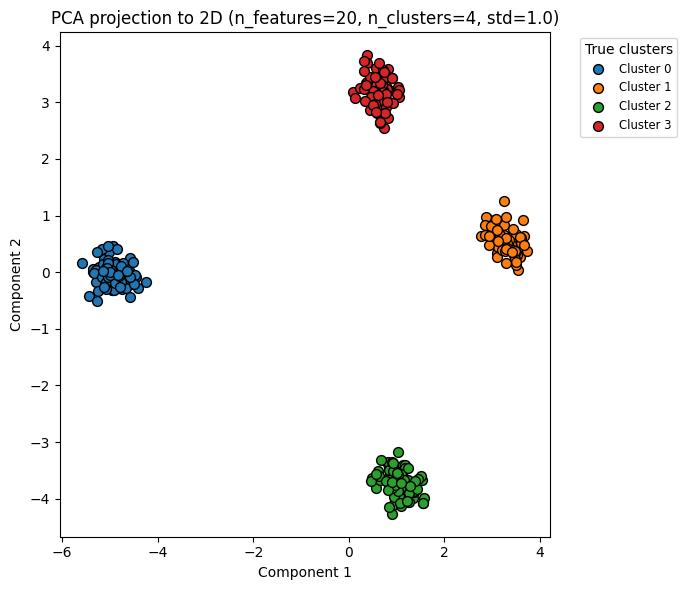

In [9]:
# Copy and execute generated code here:
# Demonstration: generate high-dimensional synthetic data, apply dimensionality reduction,
# and plot 2D projection colored by true cluster membership.
# Run: python dim_reduction_demo.py --n_samples 500 --n_features 20 --n_clusters 4 --algorithm pca

import argparse
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Try to import UMAP (optional). If not installed the script will still work with PCA/TSNE.
try:
    import umap.umap_ as umap  # type: ignore
    _HAS_UMAP = True
except Exception:
    _HAS_UMAP = False

def reduce_and_plot(n_samples=300,
                    n_features=10,
                    n_clusters=3,
                    cluster_std=1.0,
                    algorithm="pca",
                    random_state=42,
                    perplexity=30,
                    save_fig=False,
                    fname=None):
    """
    Generate synthetic high-dim data with `n_features` and `n_clusters`,
    reduce to 2D using chosen algorithm ('pca', 'tsne', 'umap' if available),
    and plot colored by true cluster labels.

    Parameters to control difficulty: n_clusters, cluster_std, n_features.
    """
    rng = np.random.RandomState(random_state)

    # 1) create synthetic high-dimensional data (make_blobs supports n_features)
    X, y = make_blobs(n_samples=n_samples,
                      centers=n_clusters,
                      n_features=n_features,
                      cluster_std=cluster_std,
                      random_state=rng)

    # Standardize features before many DR methods (recommended)
    X = StandardScaler().fit_transform(X)

    # 2) dimensionality reduction -> 2D
    algorithm = algorithm.lower()
    if algorithm == "pca":
        reducer = PCA(n_components=2, random_state=random_state)
        X2 = reducer.fit_transform(X)
    elif algorithm == "tsne":
        # TSNE can be slow for large n_samples; init='pca' often helps
        reducer = TSNE(n_components=2, random_state=random_state, perplexity=perplexity, init="pca")
        X2 = reducer.fit_transform(X)
    elif algorithm == "umap":
        if not _HAS_UMAP:
            raise RuntimeError("UMAP requested but umap-learn is not installed. Use --algorithm pca or tsne.")
        reducer = umap.UMAP(n_components=2, random_state=random_state)
        X2 = reducer.fit_transform(X)
    else:
        raise ValueError("Unsupported algorithm. Choose 'pca', 'tsne', or 'umap'.")

    # 3) visualization: scatter colored by true cluster label
    plt.figure(figsize=(7, 6))
    cmap = plt.get_cmap("tab10")
    unique_labels = np.unique(y)
    for lbl in unique_labels:
        mask = y == lbl
        plt.scatter(X2[mask, 0], X2[mask, 1],
                    s=50,
                    color=cmap(int(lbl) % 10),
                    edgecolor="k",
                    label=f"Cluster {lbl}")
    plt.title(f"{algorithm.upper()} projection to 2D (n_features={n_features}, n_clusters={n_clusters}, std={cluster_std})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="True clusters", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
    plt.tight_layout()

    if save_fig:
        if fname is None:
            fname = f"dimred_{algorithm}_n{n_samples}_f{n_features}_k{n_clusters}_std{cluster_std:.2f}.png"
        plt.savefig(fname, dpi=150)
        print("Saved figure to", fname)

    plt.show()
    plt.close()

def parse_args(argv=None):
    p = argparse.ArgumentParser(description="Dimensionality reduction demo (synthetic high-dim data -> 2D).")
    p.add_argument("--n_samples", type=int, default=300)
    p.add_argument("--n_features", type=int, default=20)
    p.add_argument("--n_clusters", type=int, default=4)
    p.add_argument("--cluster_std", type=float, default=1.0, help="Higher -> clusters overlap more (harder)")
    p.add_argument("--algorithm", type=str, default="pca", choices=["pca", "tsne", "umap"])
    p.add_argument("--perplexity", type=float, default=30.0, help="TSNE perplexity (only used if algorithm=tsne)")
    p.add_argument("--random_state", type=int, default=42)
    p.add_argument("--save_fig", action="store_true")
    p.add_argument("--fname", type=str, default=None, help="Filename to save figure when --save_fig is set")
    if argv is None:
        # ignore Jupyter/IPython injected args
        args, _ = p.parse_known_args()
    else:
        args = p.parse_args(argv)
    return args

if __name__ == "__main__":
    args = parse_args()
    if args.algorithm == "umap" and not _HAS_UMAP:
        print("UMAP not available in this environment; falling back to PCA.")
        args.algorithm = "pca"
    reduce_and_plot(n_samples=args.n_samples,
                    n_features=args.n_features,
                    n_clusters=args.n_clusters,
                    cluster_std=args.cluster_std,
                    algorithm=args.algorithm,
                    random_state=args.random_state,
                    perplexity=args.perplexity,
                    save_fig=args.save_fig,
                    fname=args.fname)


## Programming task:
If the prepared prompt worked as intended, your synthetic high-dimensional data set should comprise `num_clusters` clusters. The 2D projection of the data should also show these clusters. Let's see whether we can also find these clusters in the original, high-dimensional data using a clustering algorithm.

Specifically, drawing on the code generated in response to our first prompt, your task is to write a Python script that clusters your high-dimensional data set. 

Quickly check that *kMeans* really clustered all data points into `num_clusters` clusters by applying the `Numpy` function `unique()` to the *predicted labels* from *kMeans*. For example, your code might look as follows:
```Python
# Code to apply KMeans algorithm to the high-dimensional data set
kmeans = ... # -> for you to complete
predicted_labels = kmeans.fit_predict(data)
print(np.unique(predicted_labels))
```

We suggest you try to solve this task without the help of Gen-AI. 

Unique predicted labels (KMeans): [0 1 2 3]
Number of unique predicted clusters: 4
Label mapping (pred -> true): {3: 0, 2: 1, 1: 2, 0: 3}
Accuracy after optimal mapping: 1.0000
Adjusted Rand Index (ARI): 1.0000
Normalized Mutual Information (NMI): 1.0000


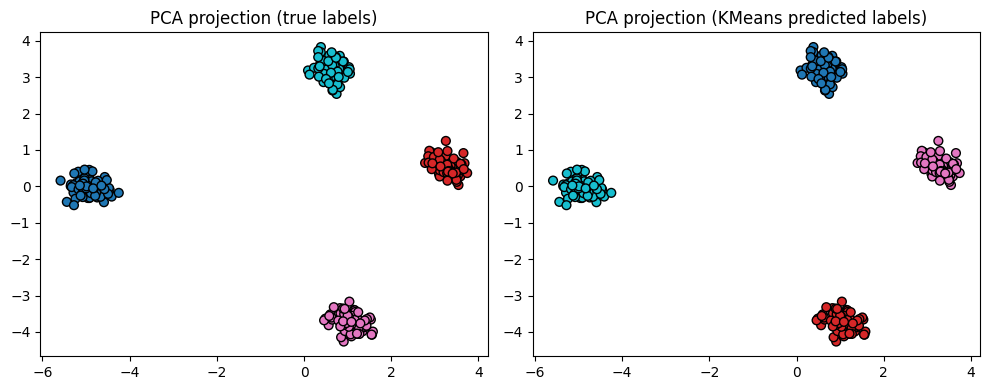

In [13]:
# Your solution goes here
# Simple script: generate high-dimensional synthetic data, run KMeans on the original data,
# print unique predicted labels and basic clustering diagnostics.
# Run inside notebook or as script. In notebooks argparse ignores injected kernel args.

import argparse
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def map_labels_hungarian(true_labels, pred_labels):
    """Map predicted cluster indices to true labels using the Hungarian algorithm."""
    cm = contingency_matrix(true_labels, pred_labels)  # rows=true, cols=pred
    row_ind, col_ind = linear_sum_assignment(-cm)      # maximize matching
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    mapped = np.array([mapping.get(p, -1) for p in pred_labels])
    return mapped, mapping

def cluster_high_dim(n_samples=300, n_features=20, n_clusters=4,
                      cluster_std=1.0, random_state=42, plot_pca=True):
    """
    Generate high-dimensional blobs, run KMeans on the original features,
    and print/check the unique predicted labels.
    """
    rng = np.random.RandomState(random_state)

    # 1) Generate synthetic high-dimensional data
    X, y_true = make_blobs(n_samples=n_samples,
                           centers=n_clusters,
                           n_features=n_features,
                           cluster_std=cluster_std,
                           random_state=rng)

    # Standardize (recommended)
    X = StandardScaler().fit_transform(X)

    # 2) Apply KMeans to the high-dimensional data
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    y_pred = kmeans.fit_predict(X)

    # Quick check: how many unique predicted labels did KMeans produce?
    uniq_pred = np.unique(y_pred)
    print("Unique predicted labels (KMeans):", uniq_pred)
    print("Number of unique predicted clusters:", len(uniq_pred))

    # 3) Optional: align predicted labels to true labels (Hungarian) and report accuracy
    y_pred_mapped, mapping = map_labels_hungarian(y_true, y_pred)
    accuracy = np.mean(y_pred_mapped == y_true)
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)

    print("Label mapping (pred -> true):", mapping)
    print(f"Accuracy after optimal mapping: {accuracy:.4f}")
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

    # 4) Small PCA plot for intuition (true vs predicted)
    if plot_pca:
        pca = PCA(n_components=2, random_state=random_state)
        X2 = pca.fit_transform(X)
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        cmap = plt.get_cmap("tab10")

        axes[0].scatter(X2[:, 0], X2[:, 1], c=y_true, cmap=cmap, edgecolor="k", s=40)
        axes[0].set_title("PCA projection (true labels)")

        axes[1].scatter(X2[:, 0], X2[:, 1], c=y_pred, cmap=cmap, edgecolor="k", s=40)
        axes[1].set_title("PCA projection (KMeans predicted labels)")

        plt.tight_layout()
        plt.show()
        plt.close(fig)

    return X, y_true, y_pred

def parse_args(argv=None):
    p = argparse.ArgumentParser(description="Cluster high-dimensional synthetic data with KMeans.")
    p.add_argument("--n_samples", type=int, default=300)
    p.add_argument("--n_features", type=int, default=20)
    p.add_argument("--n_clusters", type=int, default=4)
    p.add_argument("--cluster_std", type=float, default=1.0, help="Higher -> clusters overlap more (harder)")
    p.add_argument("--random_state", type=int, default=42)
    p.add_argument("--no_plot", action="store_true", help="Disable PCA plotting")
    if argv is None:
        args, _ = p.parse_known_args()   # safe in notebooks
    else:
        args = p.parse_args(argv)
    return args

if __name__ == "__main__":
    args = parse_args()
    cluster_high_dim(n_samples=args.n_samples,
                     n_features=args.n_features,
                     n_clusters=args.n_clusters,
                     cluster_std=args.cluster_std,
                     random_state=args.random_state,
                     plot_pca=not args.no_plot)

**Additional task for the experts:** try to find a way to verify that the algorithm found the correct number of clusters. 
While the above code is enough to solve the task, examining the resulting clustering is suitable is more challenging. 

Since we use synthetic data, an intuitive approach is to compare the true cluster membership (i.e., the variable `labels` that the `make_blobs` function returns) to the output of the `fit_predict` method. Unfortunately, this does not work because of the **arbitrary cluster indexing** in both `make_blobs` and K-means. While `make_blobs` assigns indices to clusters when generating synthetic data, K-means does not know these labels and assigns its own arbitrary indices based on how it organizes clusters during training.

This discrepancy means that even if the clustering is perfectly accurate in terms of data point grouping, the indices of clusters in `make_blobs` and K-means may not align (e.g., what `make_blobs` labels as cluster `0`, K-means might label as cluster `2`). 

To align indices for accurate comparison, we can use the **Hungarian method** to optimally map K-means cluster indices to the true labels, allowing us to objectively assess clustering performance without being affected by differing label assignments.

Using web-search and, if you like, GenAI, try to align the K-means-based cluster indices and those of `make_blobs()`. Afterwards, compute the fraction of correct cluster assignments to assess K-means. 

If you can get this pipeline to work, the next task would be to gradually increase the level of data complexity and to verify that the number of cluster assignment errors increases when the clustering task becomes more difficult.